# Deconvolving spikes from Ca2+ imaging

### Short intro to the experimental technique

A common way of measuring neural activity (spiking) is with calcium (Ca2+) indicators. These are designer proteins that are genetically inserted into all neurons or specific types of neurons. The protein has a part that senses calcium ions and another part that fluoresces when the sensor is activated.

Spiking in the neuron is an electrical phenomenon: the spike is a sharp rise in the voltage across the neuron's membrane. But it is also a chemical phenomenon: charged ions (principally Na+, K+, Cl-, and Ca2+) flowing in and out of the cell lead to this change. After a spike, Ca2+ rises sharply in the cell before decaying back to its baseline concentration.

Spiking is a fast process, happening on the order of milliseconds. Calcium transients following spiking is 1-2 orders of magnitude slower, occuring on 10-100 ms timescales. This is compounded by the effects of the Ca2+ binding to the sensor part of the indicator protein.

So in reality, the calcium signal we can measure with this technique is a smoothed out version of the underlying fast and spiky neuron firing.

### Mathematizing things

The neuron spiking (unknown) and Ca2+ measurements (known) are represented as two timeseries $s(t)$ and $x(t)$.
So the **inverse problem** of spike deconvolution is to estimate $s(t)$ given $x(t)$.

Since spiking is *fast and short-lived*, the spiking behavior will look something like:

$$
s(t) = (0, 0, 1, 0, 0, 0, 0, 0,\ldots)
$$

whereas the calcium signal that we can measure would look like 

$$
x(t) = (0, 0, 0.9, 0.35, 0.3, 0.2, 0.1, 0.05, \ldots) .
$$

The spike leads to a rapid increase but slow decay. 
(In reality, there is some finite rise time as well, but let's ignore that for simplicity.)

What is lacking so far is a description of the forward model $f: s(t) \to x(t)$.
A simple one is autoregression:

$$
x(t + 1) = \gamma x(t) + s(t+1) + \xi(t+1), \qquad \text{(AR)}
$$
where $\xi(t) \sim \mathcal{N}(0,\sigma^2)$ is a Gaussian noise term.

This AR(1) model has one free parameter, $\gamma$, along with the noise variance $\sigma^2$.

## Exercise 1 (pen & paper)
For this exercise, assume $\sigma = 0$.

* Assume $s(1) = 1$ and $s(t > 1) = 0$. Come up with a formula for $x(t)$ given the AR model for arbitrary $t = 1, 2, 3,\ldots$. 
* What kind of function is this? 
* What is the condition on $\gamma$ for the solution to be *stable* (not blow up as $t \to \infty$)?

## Exercise 2 (pen & paper)

Now we want to implement such a model on the computer. We will model a set of $T$ total timepoints
$t = 1, 2, \ldots, T$. In this case, our timeseries $x(t)$ and $s(t)$ are just vectors of length $T$ which we will denote as $\bf{x}$ and $\bf{s}$.

* Write a matrix $\bf{A}$ that represents the AR model. It should satisfy $\bf{x} = \bf{A} \bf{s}$. For boundary conditions assume there are no spikes before $t=1$. Ignore the noise term.

## Exercise 3

Below we have some code that will generate data from the AR model. Run the cell below:

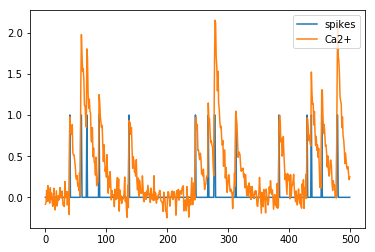

In [42]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
np.random.seed(2)

T = 500
gamma = 0.9
s = np.array(np.random.rand(T,) > 0.96)

def gen_AR_data(s, gamma = 0.9, noise = 0.1):
    x = np.zeros(len(s),)
    for t in range(len(s)):
        if t > 1:
            x[t] = gamma * x[t-1] + s[t]
        else:
            x[t] = s[t]
    x = x + np.random.randn(len(s),) * noise
    return x

x = gen_AR_data(s, gamma)

plt.plot(s)
plt.plot(x)
plt.legend(['spikes', 'Ca2+'])


* Now that we have some data, make the matrix $\bf{A}$ below. There is some code to get you started.

In [27]:
A = np.zeros((T, T))
for j in range(T):
    for i in range(j, T):
        A[i,j] = ## fill this in!

In [43]:
A = np.zeros((T, T))
for j in range(T):
    for i in range(j, T):
        A[i,j] = gamma ** (i-j)

To check that your matrix works, make a plot of ${\bf A s}$ and $\bf{x}$. They should look the same, up to the noise.

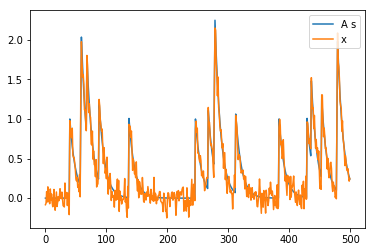

In [67]:
plt.plot(A @ s)
plt.plot(x)
plt.legend(['A s', 'x'])

## Exercise: inverse problem

Now, to recover the spikes, we have to solve
$
\bf x = A s
$
for $\bf s$.

* Solve the equation. You may want to use `np.linalg.inv` or `np.linalg.pinv`. Call your solution `shat`.
* Plot the solution `shat` as well as the truth `s`.
* What do you observe about the solution? Is it good or bad?

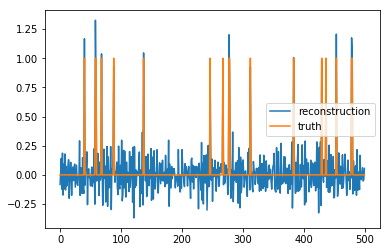

In [70]:
shat = np.linalg.pinv(A) @ x

plt.plot(shat)
plt.plot(s)
plt.legend(['reconstruction', 'truth'])
#plt.plot(s)
#plt.xlim([200,300])

## Exercise: enforcing sparsity (advanced)

We have some *prior* information about the spike train $\bf s$: it is *sparse*.

One way to force the solution to be sparse is to penalize the nonzero entries in the vector somehow.
A popular approach is LASSO. 

$$
\hat{\bf s} = \arg \min_{\bf s} \| {\bf x - A s} \|_2^2 + \alpha \| {\bf s} \|_1
$$

It has a tuning parameter $\alpha$. A larger $\alpha$ leads to a sparser solution.

It is implemented in `scikit-learn` but has a sort of weird syntax.

In [83]:
from sklearn.linear_model import Lasso

estimator = Lasso(fit_intercept = False, alpha=1e-3)

# first you have to solve the optimization problem by calling the 'fit' function
estimator.fit(A, x)
# now that it's been fit, the solution is stored in the 'coef_' argument
shat2 = estimator.coef_

* Plot the residual $\bf{ r = \hat{s} - s}$ from before and the new residual $\bf{ r = \hat{s}_2 - s}$. Is your solution any better than before?
* Plot $\bf \hat{s}$ and $\bf s$ for just the first 100 time points. Where does it make the mistakes?

(0, 140)

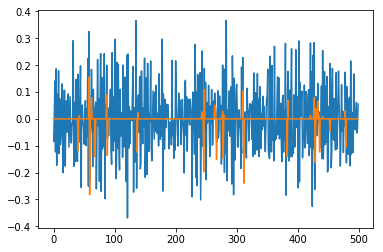

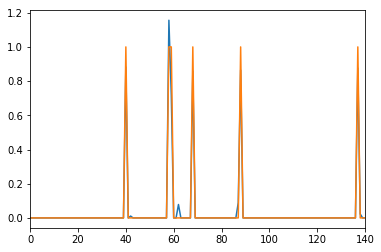

In [90]:
plt.plot(shat - s)
plt.plot(shat2 - s)

plt.figure()
plt.plot(shat2)
plt.plot(s)
plt.xlim([0, 140])

### Parameter tuning

It turns out the LASSO solution depends strongly on the parameter $\alpha$. Experiment with this and see what happens when $\alpha$ is much larger or much smaller than `1e-3`.